# Le module `PulP`, un modeleur d'optimisation lisible

In [10]:
import pulp
import itertools
import matplotlib.pyplot as plt

## 1. Le même exemple que dans le tutoriel `numpy_for_optimization.ipynb`

Pour pouvoir facilement réutiliser le problème plusieurs fois, on le définit dans une fonction.

In [44]:
x = pulp.LpVariable('x', lowBound=0, upBound=100)
y = pulp.LpVariable('y', lowBound=0, upBound=50)

lp_prob = pulp.LpProblem("blah", pulp.LpMaximize)

lp_prob += 3*x

lp_prob += y >= x

lp_prob.solve()

print('x:', x.value())
print('y:', y.value())

x: 50.0
y: 50.0


In [26]:
def optim():
    # définition des variables et des bornes
    x1 = pulp.LpVariable("production_1", 0, 100)
    x2 = pulp.LpVariable("production_2", 0, 200)

    # délcaration du problème d'optimisation
    lp_prob = pulp.LpProblem("Centrales électriques", pulp.LpMinimize)

    # fonction objectif
    lp_prob += 30*x1 + 50*x2

    # contraintes
    lp_prob += x1 + x2 == 150

    # résolution
    res = lp_prob.solve()
    
    return res

In [27]:
import time

In [28]:
print(time.time())

for i in range(100):
    optim()

print(time.time())

1513693084.4379745
1513693095.3290856


Pour résoudre 100 fois le problème, la machine a mis 11 secondes. On est à environ 10 problèmes résolus par seconde.

In [29]:
t0 = time.time()

i = 0
while (time.time()-t0 <= 1.0):
    optim()
    i += 1

print(i)

7


### 1.2. Un problème plus compliqué

On va utiliser la décomposition par les peix (voir slides du cours) pour résoudre un problème à 100 centrales très rapidement.

In [30]:
# paramètres du problème
nb_centrales = 100
costs = np.random.uniform(20, 50, size=nb_centrales)
demand = 70000

In [31]:
# fonction de résolution de chaque sous-problème (i de 0 à 99)
def suboptim(i, prix):
    if costs[i] > prix:
        return 0
    else:
        return 1000

Toujours vérifier ce qu'on a construit.

In [32]:
suboptim(2, 100)

1000

In [33]:
suboptim(5, 10)

0

In [45]:
def maitre(nbiter): # algorithme maître
    prix = [0]
    for it in range(nbiter):
        sommeprod = 0 # init
        
        # boucle de résolution des sous-problèmes
        for i in range(nb_centrales):
            sommeprod += suboptim(i, prix[-1])
            
        # mise à jour du prix
        prix.append(prix[-1] + 10**-4 * (demand - sommeprod))
        
    return prix, sommeprod

Affichons nos réultats.

In [46]:
import matplotlib.pyplot as plt

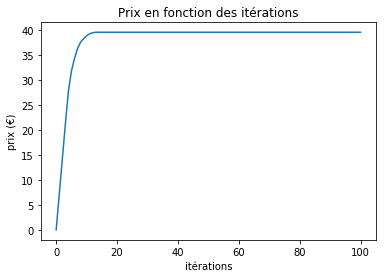

In [47]:
prix, sommeprod = maitre(100)

plt.plot(prix)
plt.title("Prix en fonction des itérations")
plt.xlabel("itérations")
plt.ylabel("prix (€)")
plt.show()

## 2. Un vrai problème (plus compliqué)

Maintenant la demande va bouger avec le temps ! Chargeons un fichier qui contient la demande.

### 2.5.1 Paramètres

In [2]:
import numpy as np
import matplotlib.pyplot as plt

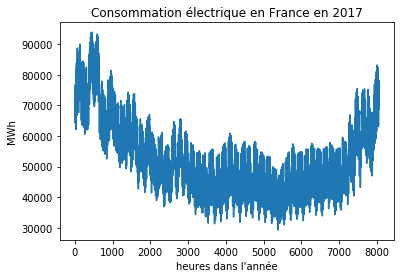

In [21]:
demand = np.genfromtxt('conso_h.csv')

plt.plot(demand)

plt.title("Consommation électrique en France en 2017")
plt.xlabel("heures dans l'année")
plt.ylabel("MWh")

plt.show()

On va se restreindre au jour de l'année ; on va donc prendre une valeur tous les 24.

In [30]:
demand = demand[::24]
print(len(demand))

336


Enregistrons une fois pour toutes l'intervalle de temps.

In [31]:
trange = np.arange(len(demand))

* On a un problème avec une centaine d'unités, qui peuvent produire entre 0 et 1000 MW.
* Leurs coûts sont uniformément distribués entre 20€ et 50€ par MWh (ils ne varient pas en fonction du temps)

In [32]:
# autres paramètres du problème (la demande est déjà définie)
nb_centrales = 100
costs = np.random.uniform(20, 50, size=nb_centrales)

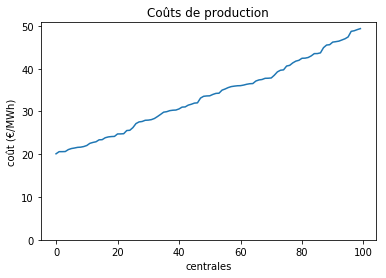

In [33]:
plt.plot(np.sort(costs))

plt.ylim(bottom=0)

plt.title("Coûts de production")
plt.xlabel('centrales')
plt.ylabel("coût (€/MWh)")
plt.show()

### 2.5.2. Algorithme de décomposition (toujours par les prix)

In [34]:
# fonction de résolution d'un sous-problème d'une unité thermique
# Attention, le prix est maintenant un np.array !!
def suboptim(cost, price):
    return 1000 * (price > cost)

Vérifions ce qu'on a fait.

In [35]:
suboptim(25, np.array([10, 20, 30]))

array([   0,    0, 1000])

In [36]:
def maitre(nbiter): # algorithme maître
    
    # on initialise notre liste des prix à chaque itération
    prix = [20 * np.ones_like(demand)]
    
    # on initialise notre liste des productions totales
    # à chaque itération
    sommeprod = []
    for it in range(nbiter):
        sommeprod.append(np.zeros_like(demand)) # init
        
        # boucle de résolution des sous-problèmes
        for i in range(nb_centrales):
            sommeprod[-1] += suboptim(costs[i], prix[-1])
            
        # mise à jour du prix
        prix.append(prix[-1] + 10**-4 * (demand - sommeprod[-1]))
        
    return prix, sommeprod

### 2.5.3. Analyse des résultats

Y'a plus qu'à.

In [37]:
prix, sommeprod = maitre(20)

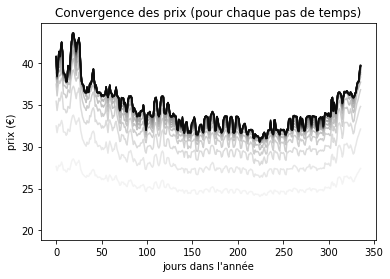

In [38]:
for i, p in enumerate(prix):
    plt.plot(p, c=str(1 - i / len(prix)))

plt.title("Convergence des prix (pour chaque pas de temps)")
plt.xlabel("jours dans l'année")
plt.ylabel("prix (€)")

plt.show()

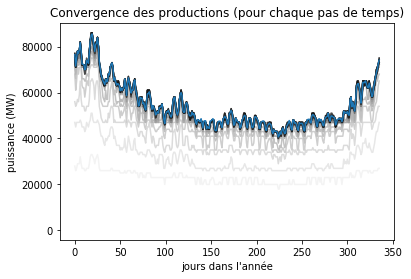

In [39]:
for i, sp in enumerate(sommeprod):
    plt.plot(sp, c=str(1 - i / len(prix)))
plt.plot(demand)

plt.title("Convergence des productions (pour chaque pas de temps)")
plt.xlabel("jours dans l'année")
plt.ylabel("puissance (MW)")

plt.show()

### 2.5.4. Hydraulique

Un stock hydraulique est une quantité d'énergie que l'on peut utiliser quand on veut dans l'année. On va supposer qu'on peut consommer tout le stock dans l'année.

Attention, il a deux variables : la production et le stock. Les deux sont bornées, et on a (si le pas de temps est journalier) :
```
    stock(t+1) = stock(t) - 24 * production(t)
```

Ajoutez un stock hydraulique de puissance max 10GW et d'énergie disponible 50 000GWh. Combien fait-il gagner au système ?

In [45]:
def suboptim_hydro(prix, stock_init=5*10**7, stock_max=5*10**7, p_max=10**4):
    """ Résoud le sous-problème sur une unité hydraulique
    """
    trange = np.arange(0, len(prix))
    trange_plus = np.arange(0, len(prix)+1)
    
    # Définition des variables
    stock = pulp.LpVariable.dicts('stock_hydro', trange_plus, 0, stock_max)
    prod = pulp.LpVariable.dicts('prod_hydro', trange, 0, p_max)
    
    lp_prob = pulp.LpProblem("Hydraulique", pulp.LpMaximize)
    
    # contraintes
    lp_prob += stock[0] == stock_init
    for t in trange:
        lp_prob += stock[t+1] == stock[t] - 24*prod[t]
    
    # gain
    gain = 0
    for t in trange:
        gain += prod[t] * prix[t]
    lp_prob += gain # ajout au modèle (fonction objectif)
    
    # résolution
    lp_prob.solve()
    
    # création de la solution
    sol = []
    for t in trange:
        sol.append(prod[t].value())
    
    return np.array(sol)

In [161]:
def suboptim_hydro(prix, stock_init=5*10**7, stock_max=5*10**7, p_max=10**4):
    """ Résoud le sous-problème sur une unité hydraulique
    """
    trange = np.arange(0, len(prix))
    trange_plus = np.arange(0, len(prix)+1)
    
    # Définition des variables
    stock = pulp.LpVariable.dicts('stock_hydro', trange_plus, 0, stock_max)
    prod = pulp.LpVariable.dicts('prod_hydro', trange, 0, p_max)
    
    # Définition du problème
    lp_prob = pulp.LpProblem("Sous-problème hydraulique", pulp.LpMaximize)
    
    # Fonction objectif
    lp_prob += sum([prix[t] * prod[t] for t in trange])
    
    # Contraintes de stock
    for t in trange_plus:
        if t == 0:
            # contrainte stock initial
            lp_prob += stock[0] == stock_init
        else:
            # Contrainte d'évolution du stock
            lp_prob += stock[t] == stock[t-1] - prod[t-1] * 24
    
    lp_prob.solve() # résolution
    
    return np.array([prod[t].value() for t in trange])

Vérifions ce que l'on a fait. On prend un prix croissant au cours de l'année.

In [46]:
suboptim_hydro(np.arange(1, 365))

array([     0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      

On a bien une production qui se concentre sur la partie de l'année où le prix est le plus haut.

In [50]:
def maitre(nbiter): # algorithme maître
    prix = [np.zeros_like(demand)]
    sommeprod = []
    for it in range(nbiter):
        sommeprod.append(np.zeros_like(demand)) # init
        
        # boucle de résolution des sous-problèmes
        for i in range(nb_centrales):
            sommeprod[-1] += suboptim(costs[i], prix[-1])
        
        # sous-problème hydraulique
        sommeprod[-1] += suboptim_hydro(prix[-1])
            
        # mise à jour du prix
        prix.append(prix[-1] + 10**-4 * (demand - sommeprod[-1]))
        
    return prix, sommeprod

Y'a plus qu'à.

In [51]:
prix, sommeprod = maitre(25)

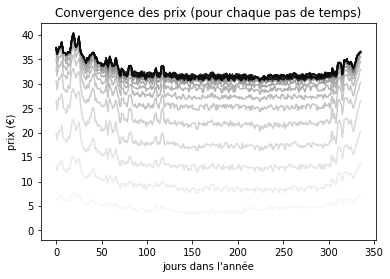

In [52]:
for i, p in enumerate(prix):
    plt.plot(p, c=str(1 - i / len(prix)))

plt.title("Convergence des prix (pour chaque pas de temps)")
plt.xlabel("jours dans l'année")
plt.ylabel("prix (€)")

plt.show()

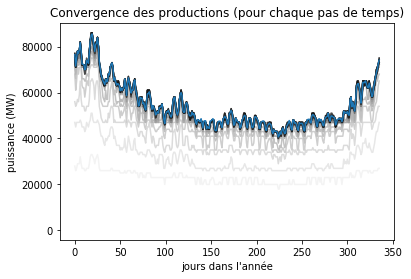

In [41]:
for i, sp in enumerate(sommeprod):
    plt.plot(sp, c=str(1 - i / len(prix)))
plt.plot(demand)

plt.title("Convergence des productions (pour chaque pas de temps)")
plt.xlabel("jours dans l'année")
plt.ylabel("puissance (MW)")

plt.show()

### 2.5.5. Données encore plus réalistes

In [174]:
costs = np.concatenate([
    np.random.uniform(10, 15, size=50),
    np.random.uniform(30, 40, size=30),
    np.random.uniform(40, 50, size=15),
    np.random.uniform(70, 99, size=5)
])

costs.shape

(100,)

In [175]:
prix, sommeprod = maitre(25)

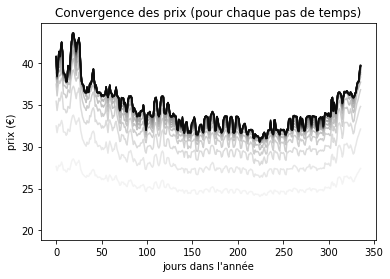

In [40]:
for i, p in enumerate(prix):
    plt.plot(p, c=str(1 - i / len(prix)))

plt.title("Convergence des prix (pour chaque pas de temps)")
plt.xlabel("jours dans l'année")
plt.ylabel("prix (€)")

plt.show()

Et sur 8760 pas de temps ? Ou bien le problème d'investissement ?